In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import sys
sys.path.append('..')
from quotaclimat.data_processing.sitemap_processing import load_all

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import gensim
from quotaclimat.data_ingestion.config_sitmap import MEDIA_CONFIG, SITEMAP_CONFIG
import datetime


stopwords = stopwords.words('french')
pd.options.display.max_colwidth = 200

# snowball steamer 
stemmer = SnowballStemmer("french")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result




In [3]:
df = load_all("../data_public/sitemap_dumps/")


In [4]:
df.columns

Index(['url', 'news', 'news_publication', 'publication_name',
       'publication_language', 'news_publication_date', 'news_title', 'image',
       'image_loc', 'image_caption', 'news_keywords', 'sitemap', 'etag',
       'sitemap_last_modified', 'sitemap_size_mb', 'download_date', 'media',
       'section', 'media_type', 'lastmod', 'news_genres', 'changefreq',
       'priority', 'news_access'],
      dtype='object')

# Feature engineering

In [5]:
print(df.news_publication_date.min())
print(df.news_publication_date.max())

2022-11-24 02:14:00
2022-12-19 02:19:53


In [6]:
# format date
df['news_publication_date'] = df.news_publication_date.dt.strftime("%Y-%m-%d")
df['download_date'] = df.download_date.dt.strftime("%Y-%m-%d")
# media type
df['type'] = df['media'].apply(lambda m: MEDIA_CONFIG[m]['type'])

# filtering
df = df[df.news_publication_date > '2022-11-24']  # some article are very old
# extract section 
mlb = MultiLabelBinarizer()
df_sparse = pd.DataFrame(mlb.fit_transform(df.section),columns=mlb.classes_, index=df.index)
df[df_sparse.columns] = df_sparse

# news title processing
df.news_title = df.news_title.str.lower()


/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_63551/4271316451.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[df_sparse.columns] = df_sparse
/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_63551/4271316451.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[df_sparse.columns] = df_sparse
/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_63551/4271316451.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

In [18]:
# title cleanup

df['nb_of_words'] = df['news_title'].str.split().str.len()
# remove channel name from extract
words_to_remove = stopwords.copy()
spelt_numbers = ['un', 'deux', 'trois', "quatre", 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix', "vingt", "trente"]
words_to_remove = words_to_remove + spelt_numbers
df['text_without_stopwords'] = df['news_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (words_to_remove)]))
df['nb_of_words_without_stopwords'] = df['text_without_stopwords'].str.split().str.len()
df['text_without_stopwords'] = df['text_without_stopwords'].str.replace('\'', '')
# remove single character 
df['text_without_stopwords'] = df['text_without_stopwords'].str.replace('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', regex=True)


# snowball stemmer
processed_titles = []
for title in df['text_without_stopwords']:
    processed_titles.append(preprocess(title))

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/Users/estelle/nltk_data'
    - '/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/nltk_data'
    - '/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/share/nltk_data'
    - '/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [15]:
# snowball stemmer
processed_titles = []
for title in df['text_without_stopwords']:
    processed_titles.append(preprocess(title))

KeyError: 'text_without_stopwords'

# EDA

In [17]:
df_count_pub_date_media = df.groupby(['news_publication_date', 'media'], as_index=False).count()
keywords = ['COP27', 'écologie']
keywords_comp = ['marcon', 'qatar']

In [18]:
keywords = ['COP27', 'écologie']
keywords_comp = ['marcon', 'qatar']

In [19]:
df['day_of_the_month'] = df.download_date.str[-5:]

df.groupby(["type", 'day_of_the_month']).count()

url  news  news_publication  publication_name  \
type     day_of_the_month                                                   
tv       11-27             1038   297               297              1038   
         11-30             1363   363               363              1363   
         12-01             1388   388               388              1388   
         12-03             1390   390               390              1390   
         12-04             1081   324               324              1081   
         12-05              732   261               261               732   
         12-06             1141   299               299              1141   
         12-07             1351   351               351              1351   
         12-08             1359   359               359              1359   
         12-09             1357   357               357              1357   
         12-10             1350   350               350              1350   
         12-11             1070   311               311              1070   
webpress 11-27             1346   678               678              1346   
         11-30             2005  1047              1047              2005   
         12-01             1990  1086              1086              1990   
         12-03             1849  1009              1009              1849   
         12-04             1451   761               761              1451   
         12-05             1102   553               553              1102   
         12-06             1416   736               736              1416   
         12-07             1742   967               967              1742   
         12-08             1815  1003              1003              1815   
         12-09             1871  1019              1019              1871   
         12-10             1955  1094              1094              1955   
         12-11             1592   862               862              1592   

                           publication_language  news_publication_date  \
type     day_of_the_month                                                
tv       11-27                             1038                   1038   
         11-30                             1363                   1363   
         12-01                             1388                   1388   
         12-03                             1390                   1390   
         12-04                             1081                   1081   
         12-05                              732                    732   
         12-06                             1141                   1141   
         12-07                             1351                   1351   
         12-08                             1359                   1359   
         12-09                             1357                   1357   
         12-10                             1350                   1350   
         12-11                             1070                   1070   
webpress 11-27                             1346                   1346   
         11-30                             2005                   2005   
         12-01                             1990                   1990   
         12-03                             1849                   1849   
         12-04                             1451                   1451   
         12-05                             1102                   1102   
         12-06                             1416                   1416   
         12-07                             1742                   1742   
         12-08                             1815                   1815   
         12-09                             1871                   1871   
         12-10                             1955                   1955   
         12-11                             1592                   1592   

                           news_title  image  image_loc  image_caption  ...  \
type     day_of_the_m

In [83]:
((df_between_two_dates.groupby(["type", 'download_date']).count()/df_between_two_dates.groupby(["type", 'download_date']).count()).news_title * 100)

type      download_date
tv        2022-12-01       100.0
          2022-12-03       100.0
          2022-12-04       100.0
          2022-12-05       100.0
          2022-12-06       100.0
          2022-12-07       100.0
webpress  2022-12-01       100.0
          2022-12-03       100.0
          2022-12-04       100.0
          2022-12-05       100.0
          2022-12-06       100.0
          2022-12-07       100.0
Name: news_title, dtype: float64

In [97]:
round((df_between_two_dates_kw.groupby(["type", 'download_date']).count()/df_between_two_dates.groupby(["type", 'download_date']).count()).news_title * 100, 2)

type      download_date
tv        2022-12-01        NaN
          2022-12-03        NaN
          2022-12-04        NaN
          2022-12-05        NaN
          2022-12-06        NaN
          2022-12-07       0.22
webpress  2022-12-01       0.05
          2022-12-03       0.11
          2022-12-04       0.14
          2022-12-05       0.27
          2022-12-06       0.07
          2022-12-07       0.11
Name: news_title, dtype: float64

In [78]:
keywords = ['COP27', 'écologie', "déforestation", 'COP15']
keywords_comp = ['marcon', 'qatar']

In [77]:

df.section

0     [replay-radio, les-informes-de-france-info]
1                                [coupe-du-monde]
2                                     [politique]
3      [sante, maladie, coronavirus, confinement]
4                  [politique, adrien-quatennens]
                         ...                     
61                                       [social]
62                                        [monde]
63                                        [monde]
64                                     [economie]
65                                      [justice]
Name: section, Length: 34754, dtype: object

In [71]:
df[(df.publication_name == '20minutes.fr')&(df.section == '[coupe-du-monde]')]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [67]:
df.section

0     [replay-radio, les-informes-de-france-info]
1                                [coupe-du-monde]
2                                     [politique]
3      [sante, maladie, coronavirus, confinement]
4                  [politique, adrien-quatennens]
                         ...                     
61                                       [social]
62                                        [monde]
63                                        [monde]
64                                     [economie]
65                                      [justice]
Name: section, Length: 34754, dtype: object

In [ ]:
d = st.date_input(
    "When's your birthday",
    datetime.date(2019, 7, 6))

In [25]:
df.download_date.min()

'2022-11-27'

In [79]:
df_keywords_1 = df[df.news_title.str.contains("|".join(keywords))]


figs_percentage = []

def fig_percentage_total
df_gb_1 = ((df_keywords_1.groupby("type").count()/df.groupby("type").count()).news_title * 100).reset_index()
df_gb_1["keyword list"] = ", ".join(keywords)[:25] + "..."
figs_percentage.append(px.bar(
    df_gb_1,
    x="type",
    y="news_title",
    title="Pourcentage de couverture total depuis début de la collection de la data %s"%df.download_date.min(),
    labels={'news_title': ' %', 'type':'Type de média'}
))
# entre deux dates

date_upper_bound = datetime.datetime.today()
date_lower_bound = datetime.datetime.today() - datetime.timedelta(weeks = 1)
def fig_percentage_between_two_dates_per_day_and_leaderboard_per_media(df,date_upper_bound, date_lower_bound ):
    figs_percentage = []


    df_between_two_dates = df[(pd.to_datetime(df.download_date).dt.date >= date_lower_bound)&(pd.to_datetime(df.download_date).dt.date <= date_upper_bound)]
    df_between_two_dates['day_of_the_month'] = df_between_two_dates.download_date.str[-5:]
    df_between_two_dates_kw = df_between_two_dates[df_between_two_dates.news_title.str.contains("|".join(keywords))]

    df_gb_1 = round((df_between_two_dates_kw.groupby(["type", 'download_date']).count()/df_between_two_dates.groupby(["type", 'download_date']).count()).news_title * 100, 2).reset_index()
    df_gb_1["keyword list"] = ", ".join(keywords)[:25] + "..."
    figs_percentage.append(px.bar(
        df_gb_1,
        x="download_date",
        y="news_title",
        color="type",
        title="Pourcentage de couverture total entre %s et %s"%(date_lower_bound.strftime('%Y-%m-%d'), date_upper_bound.strftime('%Y-%m-%d')),
        labels={'news_title': 'Pourcentage', 'download_date':'Jour d indexing'}
    ))

    df_gb_per_media = round((df_between_two_dates_kw.groupby(["publication_name", 'type']).count()/df_between_two_dates.groupby(["publication_name", 'type']).count()).news_title * 100, 2).reset_index()
    df_gb_per_media["keyword list"] = ", ".join(keywords)[:25] + "..."
    df_gb_per_media = df_gb_per_media.sort_values('news_title', ascending=False)

    figs_percentage.append(px.bar(
        df_gb_per_media,
        x="publication_name",
        y="news_title",
        color='type',
        title="Classement des médias entre %s et %s"%(date_lower_bound.strftime('%Y-%m-%d'), date_upper_bound.strftime('%Y-%m-%d')),
        labels={'news_title': 'Pourcentage', 'publication_name':'Media'}
    ))
    return figs_percentage


df_gb_per_media = round((df_between_two_dates_kw.groupby(["publication_name", 'type']).count()/df_between_two_dates.groupby(["publication_name", 'type']).count()).news_title * 100, 2).reset_index()
df_gb_per_media["keyword list"] = ", ".join(keywords)[:25] + "..."
df_gb_per_media = df_gb_per_media.sort_values('news_title', ascending=False)

figs_percentage.append(px.bar(
    df_gb_per_media,
    x="publication_name",
    y="news_title",
    color='type',
    title="Classement des médias entre %s et %s"%(date_lower_bound.strftime('%Y-%m-%d'), date_upper_bound.strftime('%Y-%m-%d')),
    labels={'news_title': 'Pourcentage', 'publication_name':'Media'}
))


figs_percentage[2].show()
#figs_percentage[1].show()

/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_40959/1142259465.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
# Classement between de two dates

df_gb_per_media.sort_values('news_title', ascending=False)

,publication_name,news_title,keyword list
4,L'Express,0.65,"COP27, écologie, déforest..."
3,Franceinfo,0.52,"COP27, écologie, déforest..."
5,L'Obs,0.51,"COP27, écologie, déforest..."
9,Libération,0.48,"COP27, écologie, déforest..."
7,Le Monde,0.38,"COP27, écologie, déforest..."
1,BFM Business,0.27,"COP27, écologie, déforest..."
8,Le Point,0.25,"COP27, écologie, déforest..."
0,20minutes.fr,0.23,"COP27, écologie, déforest..."
2,BFMTV,0.20,"COP27, écologie, déforest..."
6,Le Figaro,0.16,"COP27, écologie, déforest..."


In [8]:
fig = go.Figure()
trace_temporal_split = []
trace_temporal_split.append( px.bar(
    df_count_pub_date_media,
    x="news_publication_date",
    y="news_title",
    color='media',
))

fig.update_xaxes(tickangle=-45, title=None)
fig.update_yaxes(title=None)
fig.update_layout(margin={"b": 100}, title_text='Nombre total d article par jour par media')

fig.show()

In [ ]:
 traces_cultivar.append(
            go.Scatter(
                x=np.log(trn_set.total_radiation_sum_j_cm2),
                y=fruit_dev_rate_out_new,
                marker_color=colors_line[i],
                mode="markers",
                name="%s_pr_coefficient_radiation" % cultivar,
            )
        )
        traces_cultivar.append(
            go.Scatter(
                x=np.log(trn_set.total_radiation_sum_j_cm2),
                y=fruit_dev_rate_out_current,
                mode="markers",
                marker_color=colors_line[i],
                opacity=0.8,
                marker_symbol="x",
                name="%s_%s_coefficient_radiation" % (cultivar, model_version),
            )
        )

        buttons.append(
            dict(
                method="restyle",
                label=cultivar,
                visible=True,
                args=[{"visible": False}, [i for i, x in enumerate(traces_cultivar) if cultivar in x.name]],
                args2=[{"visible": True}, [i for i, x in enumerate(traces_cultivar) if cultivar in x.name]],
            )
        )

        traces = traces + traces_cultivar
        i += 1
    # create the layout
    layout = go.Layout(
        updatemenus=[dict(type="buttons", direction="right", x=0.7, y=1.3, showactive=True, buttons=buttons)],
        title=dict(text="Toggle Traces", x=0.5),
        showlegend=True,
    )

    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text="Comparing sensitivity total_radiation_sum_j_cm2",
        xaxis_title="np.log(trn_set.total_radiation_sum_j_cm2)",
        yaxis_title="Fruit development days",
    )

## Section exploration

In [18]:
# top n sections
top_n = 70
df_count_sections = df_sparse.sum(axis=0).sort_values(ascending=False).head(top_n)
fig = go.Figure()
fig.add_trace(go.Bar(y=df_count_sections, x=df_count_sections.index))
fig.update_xaxes(tickangle=-45, title=None)
fig.update_yaxes(title=None)
fig.update_layout(margin={"b": 100}, title_text='Nombre total d article par section')

In [10]:
df_sum_media = df.groupby("media").sum()

/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_49367/4276735208.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [11]:
nb_section_per_media = df_sum_media.shape[1] - df_sum_media[df_sum_media==0].isna().sum(axis=1)
print(nb_section_per_media)

media
20_minutes      717
bfmtv           518
francetvinfo    409
le_point        714
lefigaro        666
lemonde         731
lexpress        748
liberation      723
nouvel_obs      741
dtype: int64


In [93]:
SECTION_CLIMAT = ['planete', 'environnement', 'crise-climatique']



In [94]:
df[df.publication_name == 'Le Figaro'].section
keywords = [' cop27', '  cop ', 'climatique', 'écologie', 'CO2', 'effet de serre', 'transition énergétique', 'carbone']

df[(df.news_title.str.contains("|".join(keywords)))&(df.publication_name == 'Le Figaro')].news_title


54     en cas de dissolution de l'assemblée, jadot veut une coalition de gauche «rééquilibrée» en faveur de l'écologie
356                                   le changement climatique, grand absent des fictions au cinéma et à la télévision
658                                               l'eau est un puissant marqueur du changement climatique, selon l'onu
348                                    susan neiman: «la crise climatique a transformé l'idée du mal dans notre monde»
198                                    susan neiman: «la crise climatique a transformé l'idée du mal dans notre monde»
724                                   le changement climatique, grand absent des fictions au cinéma et à la télévision
Name: news_title, dtype: object

In [95]:
df_nb_in_climat_section = df[SECTION_CLIMAT + ['publication_name']].groupby("publication_name").sum().sum(axis=1)
df_nb_total = df.groupby("publication_name").sum().sum(axis=1)
percentage_article_in_climat_sections = df_nb_in_climat_section/df_nb_total * 100

/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_49367/1098075480.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [47]:

# top n sections
top_n = 10
percentage_article_in_climat_sections = percentage_article_in_climat_sections.sort_values(ascending=False).head(top_n)
fig = go.Figure()
fig.add_trace(go.Bar(y=percentage_article_in_climat_sections, x=percentage_article_in_climat_sections.index))
fig.update_xaxes(tickangle=-45, title=None)
fig.update_yaxes(title=None)
fig.update_layout(margin={"b": 100}, title_text='Pourcentage d article dans la section climat par publisher')

In [110]:
keywords = [' cop27', '  cop ', 'climatique', 'écologie', 'CO2', 'effet de serre', 'transition énergétique', 'carbone']

df[df.news_title.str.contains("|".join(keywords))].section


15                                       [meteo, climat]
9               [monde, environnement, crise-climatique]
19                      [replay-jt, france-2, 20-heures]
92              [monde, environnement, crise-climatique]
227                                     [monde, espagne]
291                                      [meteo, orages]
318             [monde, environnement, crise-climatique]
219             [monde, environnement, crise-climatique]
229                     [replay-jt, france-2, 20-heures]
295             [monde, environnement, crise-climatique]
185               [politique, europe-ecologie-les-verts]
270                                              [meteo]
642             [economie, replay-emissions, bfm-bourse]
704                                           [economie]
783    [economie, replay-emissions, good-evening-busi...
882                 [var, replay-emissions, bonsoir-var]
921                                              [meteo]
54                             

In [114]:
df.news_title.str.len().max()

304

In [116]:
df[(df.planete !=0)|(df.environnement !=0)|(df['crise-climatique'] !=0)].news_title

176                                                                      chili : le désert d'atacama, la décharge du monde
185                                                                   black friday : un vendredi noir pour l'environnement
220                                   chili : le désert d'atacama, une splendeur de la nature devenue la décharge du monde
265    ludovic, éboueur star de tiktok : "je vais faire paris-marseille à pied pour sensibiliser au ramassage des déchets"
9                               dérèglement climatique : l'année 2022 est d'ores et déjà la plus chaude jamais enregistrée
                                                              ...                                                         
42                                                       electricité : avec quels pays la france est-elle interconnectée ?
61                                                         crise de l'eau : "il faut un véritable plan marshall en france"
14              

# Find back news from other sections

## Similarity score

In [100]:
vectorizer = TfidfVectorizer(max_df=0.3, min_df=0.01, stop_words=stopwords)
df_tfidf = vectorizer.fit_transform(df['news_title'])                                                                                                                                                                                               


In [101]:
df_tfidf_sum = pd.DataFrame(df_tfidf.T.sum(axis=1), index=vectorizer.get_feature_names(), columns=["tfidf_sum"])

/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



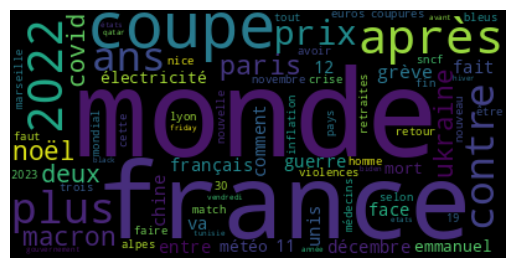

In [102]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=df_tfidf_sum.to_dict()['tfidf_sum'])
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [58]:
df[(df.planete !=0)|(df.environnement !=0)|(df['crise-climatique'] !=0) | (df[SECTION_CLIMAT] == 1).any(axis=1)].news_title

176                                                                      chili : le désert d'atacama, la décharge du monde
185                                                                   black friday : un vendredi noir pour l'environnement
220                                   chili : le désert d'atacama, une splendeur de la nature devenue la décharge du monde
265    ludovic, éboueur star de tiktok : "je vais faire paris-marseille à pied pour sensibiliser au ramassage des déchets"
9                               dérèglement climatique : l'année 2022 est d'ores et déjà la plus chaude jamais enregistrée
                                                              ...                                                         
65                                electricité : foyers, créneaux, services touchés... le délestage tournant, mode d'emploi
66                            climat : année la plus chaude, sécheresse des sols historique... les tristes records de 2022
14              

In [97]:
print(df.shape)

(14901, 799)


In [114]:
import datetime

In [115]:
a_week_ago = datetime.datetime.today() - datetime.timedelta(weeks = 1)
df[pd.to_datetime(df.download_date) > a_week_ago]

,url,news,news_publication,publication_name,publication_language,news_publication_date,news_title,image,image_loc,image_caption,...,voile,votre-sante,vox,voyage,voyages,vrai-ou-fake,web,week-end-direct,week-end-premiere,xv-de-france
0,https://www.francetvinfo.fr/culture/patrimoine/baguette-au-patrimoine-de-l-humanite-elle-pourrait-etre-en-danger-previent-la-confederation-nationale-de-la-boulangerie_5513826.html,\n,\n,Franceinfo,fr,2022-12-01,"baguette au patrimoine de l'humanité : ""elle pourrait être en danger"", prévient la confédération nationale de la boulangerie",\n,https://www.francetvinfo.fr/image/761girqmc-7e13/570/320/29981352.jpg,None,...,0,0,0,0,0,0,0,0,0,0
1,https://www.francetvinfo.fr/politique/gouvernement-d-elisabeth-borne/elisabeth-borne-declenche-a-nouveau-le-49-3-sur-le-projet-de-budget-de-la-secu-la-nupes-va-deposer-une-motion-de-censure_551334...,\n,\n,Franceinfo,fr,2022-12-01,"elisabeth borne déclenche à nouveau le 49.3 sur le projet de budget de la sécu, la nupes va déposer une motion de censure",\n,https://www.francetvinfo.fr/image/761giqnig-4292/570/320/29977410.jpg,"La Première ministre Elisabeth Borne à l'Assemblée nationale, à Paris, le 29 novembre 2022.",...,0,0,0,0,0,0,0,0,0,0
2,https://www.francetvinfo.fr/coupe-du-monde/coupe-du-monde-2022-la-fff-va-deposer-une-reclamation-contre-l-annulation-du-but-d-antoine-griezmann-face-a-la-tunisie_5513811.html,\n,\n,Franceinfo,fr,2022-12-01,coupe du monde 2022 : la fff va déposer une réclamation contre l'annulation du but d'antoine griezmann face à la tunisie,\n,https://www.francetvinfo.fr/image/761girqry-3fcd/570/320/29981163.jpg,"L'arbitre néozélandais Matthew Conger refuse le but d'Antoine Griezmann face à la Tunisie, le 30 novembre 2022 à Al Rayyan.",...,0,0,0,0,0,0,0,0,0,0
3,https://www.francetvinfo.fr/monde/europe/manifestations-en-ukraine/guerre-en-ukraine-un-pays-depourvu-d-electricite_5513670.html,\n,\n,Franceinfo,fr,2022-12-01,"video. guerre en ukraine : privés d'électricité, des habitants vivent dans le noir",\n,https://www.francetvinfo.fr/image/761girb3x-5224/570/320/29980299.jpg,"Mercredi 30 novembre, de nombreux Ukrainiens devaient toujours s'habituer à vivre dans le noir, sans électricité, après que plusieurs bombardements russes ont détruit les infrastructures électriques.",...,0,0,0,0,0,0,0,0,0,0
4,https://www.francetvinfo.fr/monde/europe/manifestations-en-ukraine/direct-guerre-en-ukraine-kiev-appelle-les-pays-de-l-otan-a-accelerer-la-livraison-d-armes-et-d-equipements-electriques_5512311.html,\n,\n,Franceinfo,fr,2022-11-30,"guerre en ukraine : le chef de la diplomatie américaine qualifie de ""barbares"" les frappes russes visant les infrastructures ukrainiennes",\n,https://www.francetvinfo.fr/image/761gipxw8-ae9a/570/320/29973441.jpg,"Le secrétaire d'Etat américain Anthony Blinken, lors d'un forum à Muenster, en Allemagne, le 3 novembre 2022.",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,https://www.nouvelobs.com/moyen-orient/20221129.OBS66514/l-iran-reconnait-plus-de-300-morts-depuis-le-debut-des-manifestations-dans-le-pays.html,\n,\n,L'Obs,fr,2022-11-29,"manifestations en iran : au moins 300 morts selon les autorités, depuis le décès de mahsa amini en septembre",\n,https://focus.nouvelobs.com/2022/11/29/223/0/2048/1024/640/310/60/0/3eed641_afp-32rq4vy.jpg,"Une femme sans voile lors des funérailles de Mahsa Amini, à Aichi (Iran), le 26 octobre 2022.",...,0,0,0,0,0,0,0,0,0,0
83,https://www.nouvelobs.com/justice/20221129.OBS66512/le-gynecologue-emile-darai-continuera-ses-consultations-publiques-malgre-sa-mise-en-examen.html,\n,\n,L'Obs,fr,2022-11-29,"emile daraï, le gynécologue de l’hôpital tenon mis en examen pour « violences volontaires » sur 32 femmes, pourra continuer ses consultations publiques",\n,https://focus.nouvelobs.com/2022/11/24/787/0/5000/2500/640/310/60/0/744eb65_1669302377431-080-hl-slibermann-1549632.jpg,"Une manifestation contre les violences gynécologiqu

/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



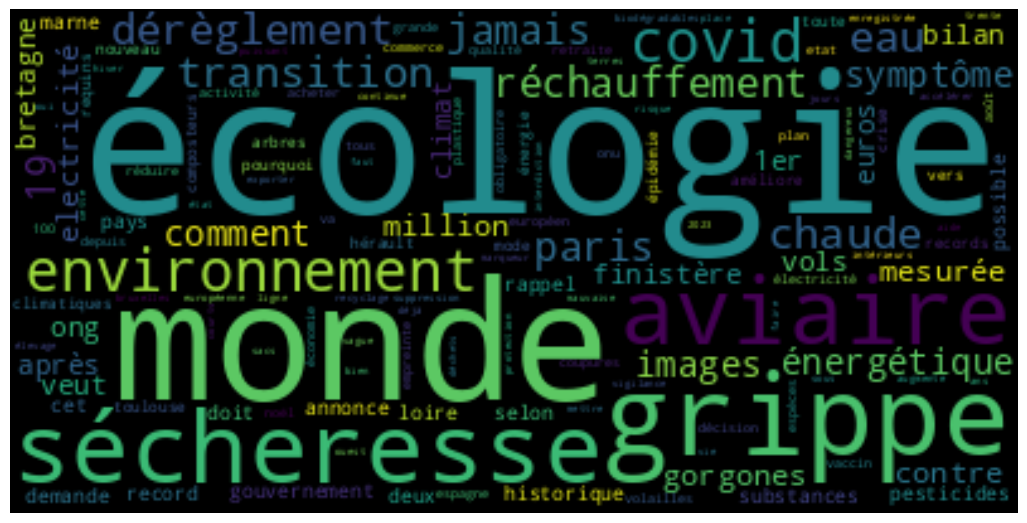

In [98]:
## word cloud per section
## here filtered only on section planete, crise climatique and environnment


climate_keywords = [' cop27', '  cop ', 'climatique', 'écologie', 'CO2', 'effet de serre', 'transition énergétique', 'carbone', 'sécheresse' 'transition énergétique', 'méthane', 'GIEC', 'zéro émission']


vectorizer = TfidfVectorizer(max_df=0.06, min_df=0.01, stop_words=stopwords)
df_positive_climat_topic = df[df.news_title.str.contains("|".join(climate_keywords)) | (df[SECTION_CLIMAT] == 1).any(axis=1)].news_title
tfidf_positive_climat_topic = vectorizer.fit_transform(df_positive_climat_topic)
tfidf_positive_climat_topic_sum = pd.DataFrame(tfidf_positive_climat_topic.T.sum(axis=1), index=vectorizer.get_feature_names(), columns=["tfidf_sum"])

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=tfidf_positive_climat_topic_sum.to_dict()['tfidf_sum'])
plt.figure(figsize=(13,8))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


/Users/estelle/.pyenv/versions/3.10.2/envs/quotaclimat/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



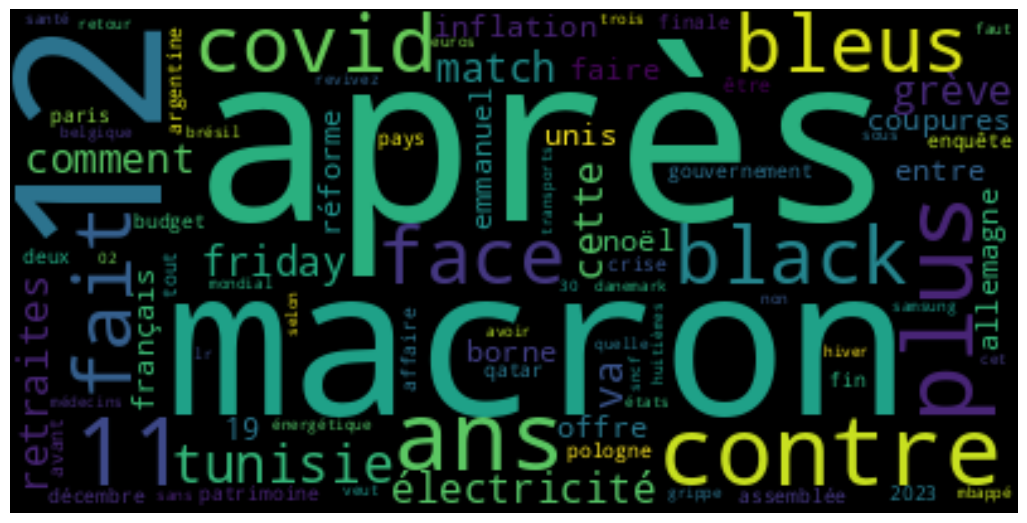

In [86]:
## word cloud per section
## Here we try to build a data set with only non climat topics

NON_CLIMAT_SECTION = ['football', "sport", 'coupe-du-monde', 'sante', 'justice', 'moyen-orient', 'tech', 'crypto', 'gaming', "economie", 'culture']

vectorizer = TfidfVectorizer(max_df=0.06, min_df=0.01, stop_words=stopwords)
df_negative_climat_topic = df[(df.politique !=0)|(df['economie'] !=0)| (df[NON_CLIMAT_SECTION] == 1).any(axis=1)].news_title

tfidf_negative_climat_topic = vectorizer.fit_transform(df_negative_climat_topic)
tfidf_negative_climat_topic_sum = pd.DataFrame(tfidf_negative_climat_topic.T.sum(axis=1), index=vectorizer.get_feature_names(), columns=["tfidf_sum"])

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=tfidf_negative_climat_topic_sum.to_dict()['tfidf_sum'])
plt.figure(figsize=(13,8))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Classifier

In [87]:
df_positive_climat_topic.shape

(223,)

In [84]:
df_negative_climat_topic.shape

(4963,)

# Topic modeling

In [88]:
## pre-process corpus
corpus = df['news_title']

lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)


In [89]:
import gensim

id2word = gensim.corpora.Dictionary(lst_corpus)
extracts = [id2word.doc2bow(word) for word in lst_corpus] 
## train LDA
nb_topics = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=extracts, id2word=id2word, num_topics=nb_topics, random_state=30, alpha='auto', per_word_topics=True)

In [90]:
# to dataframe
lst_dics = []
for i in range(0, nb_topics):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
df_all_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

In [91]:
df_all_topics.head(20)

,topic,id,word,weight
0,0,18,du monde,0.012934
1,0,1968,grève des,0.011147
2,0,86,en france,0.009429
3,0,3573,une loi,0.006712
4,0,1627,gaël perdriau,0.006337
5,0,367,?,0.005659
6,0,1606,au moins,0.005178
7,0,66,la coupe,0.004927
8,0,2384,pour avoir,0.004442
9,0,1970,médecins libéraux,0.004315


In [92]:
for idx, topic in lda_model.print_topics(-1):
   print('Topic: {} \nWords: {}'.format(idx, topic))


Topic: 0 
Words: 0.013*"du monde" + 0.011*"grève des" + 0.009*"en france" + 0.007*"une loi" + 0.006*"gaël perdriau" + 0.006*"?" + 0.005*"au moins" + 0.005*"la coupe" + 0.004*"pour avoir" + 0.004*"médecins libéraux"
Topic: 1 
Words: 0.021*"?" + 0.016*"emmanuel macron" + 0.014*"chine :" + 0.012*"de la" + 0.011*"sur les" + 0.010*": «" + 0.010*"aux etats-unis" + 0.010*"sur la" + 0.008*"et la" + 0.008*"manifestations en"
Topic: 2 
Words: 0.013*"dans les" + 0.013*"un homme" + 0.011*"sur le" + 0.011*"dans une" + 0.010*"de noël" + 0.010*"de paris" + 0.007*""zéro covid"" + 0.007*": un" + 0.007*"twitter :" + 0.006*"par un"
Topic: 3 
Words: 0.080*"coupe du" + 0.043*"monde 2022" + 0.026*"monde :" + 0.016*"novembre 2022" + 0.014*": les" + 0.013*": la" + 0.009*"mercredi 30" + 0.008*"?" + 0.007*"face à" + 0.007*"en chine"
Topic: 4 
Words: 0.015*"france" + 0.013*"pour les" + 0.008*"2022" + 0.007*"fin de" + 0.007*"« les" + 0.006*"monde au" + 0.006*"violences conjugales" + 0.006*"macron" + 0.005*"en ukr